## Heart Disease Prediction (Python Project Group - 14)

**1. CREATE NORMALIZED DATABASE** (30 Marks)

1. Using Raw Data File for Heart Disease Prediction
2. Normalizing the data
3. Using CSV module
4. Creation of tables
5. Connecting to SQLITE3 for loading data

In [3]:
import uuid
import sqlite3
from sqlite3 import Error
import pandas as pd


def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

def insert_pateint_data_values(table_name,param_length,conn,values):
    placeholders = ', '.join(['?'] * param_length)
    sql_statement = f'INSERT INTO {table_name} VALUES({placeholders})'
    cur = conn.cursor()
    cur.executemany(sql_statement, values)
    conn.commit()

# Getting Data from CSV File
def generate_patient_table_data(filename):
    patient_info = []
    patient_clinical_info = []
    header = None
    with open(filename,'r') as file:
        for line in file:
            if not line.strip():
                continue
            if not header:
                header = line.split(",")
                continue
            heart_data = line.strip().split(",")

            patient_id = str(uuid.uuid4())

            age,sex,chest_pain,blood_pressure,cholestrol,fasting_blood_sugar,ecg = heart_data[0:7]
            max_heart_rate,angina,peak,slope,flourosopy,reversable_defect,target = heart_data[7:14]
            age_category,smoker_type,treatment_type = heart_data[14:]

            patient_info.append((patient_id,age,sex,age_category,smoker_type))
            patient_clinical_info.append((patient_id,chest_pain,blood_pressure,cholestrol,fasting_blood_sugar,ecg,max_heart_rate,angina,peak,slope,flourosopy,reversable_defect,target,treatment_type))
 
        return patient_info,patient_clinical_info

# Fetching the data
patient_data = generate_patient_table_data('updated_heart.csv')
patient_info = patient_data[0]
patient_clinical_info = patient_data[1]


conn = create_connection('heart_disease_prediction_data_normalized.db',False)

#SQL Table CREATION FUNCTION
def generate_pateint_table():
    patient_info_table = '''
    CREATE TABLE IF NOT EXISTS PatientInfo (
        PatientID TEXT PRIMARY KEY,
        Age INTEGER,
        Sex INTEGER,
        AgeCategory TEXT,
        Smoker TEXT
    )
    '''
    patient_clinical_info_table = '''
    CREATE TABLE IF NOT EXISTS ClinicalInfo (
        PatientID TEXT,
        ChestPain INTEGER,
        BloodPressure INTEGER,
        Cholesterol INTEGER,
        FastingBloodSugar INTEGER,
        ECG INTEGER,
        MaxHeartRate INTEGER,
        Angina INTEGER,
        Peak DECIMAL,
        Slope INTEGER,
        Flourosopy INTEGER,
        ReversableDefect INTEGER,
        Target INTEGER,
        TreatmentType TEXT,
        FOREIGN KEY (PatientID) REFERENCES PatientInfo(PatientID)
    )
    '''

    #Table Creation
    create_table(conn,patient_info_table)
    create_table(conn,patient_clinical_info_table)

#INSERT VALUES TO DATABASE
def insert_patient_table_values_in_sqlite():
    insert_pateint_data_values('PatientInfo',5,conn,patient_info)
    insert_pateint_data_values('ClinicalInfo',14,conn,patient_clinical_info)
        
generate_pateint_table()
insert_patient_table_values_in_sqlite()


In [4]:
sql_query = '''
SELECT
    pi.Age,
    pi.Sex,
    ci.ChestPain,
    ci.BloodPressure,
    ci.Cholesterol,
    ci.FastingBloodSugar,
    ci.ECG,
    ci.MaxHeartRate,
    ci.Angina,
    ci.Peak,
    ci.Slope,
    ci.Flourosopy,
    ci.ReversableDefect,
    ci.Target,
    pi.AgeCategory,
    pi.Smoker,
    ci.TreatmentType
FROM
    PatientInfo pi
JOIN
    ClinicalInfo ci ON pi.PatientID = ci.PatientID
'''


df = pd.read_sql_query(sql_query, conn)

df.head()

,Age,Sex,ChestPain,BloodPressure,Cholesterol,FastingBloodSugar,ECG,MaxHeartRate,Angina,Peak,Slope,Flourosopy,ReversableDefect,Target,AgeCategory,Smoker,TreatmentType
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,Adult,Current Smoker,Surgery
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,Adult,Non-Smoker,Surgery
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,Senior,Current Smoker,Surgery
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,Senior,Current Smoker,Lifestyle Changes
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,Senior,Non-Smoker,Medication


**2. DATA PREPROCESSING** (20 Marks)

1. Fetch Data Using SQL Statement FROM SQLITE3 Database
2. Perform train/test split before insepecting data and Stratify data
3. Limit EDA to train data only
4. Utilize ydata profiling
5. Point Breakdown:
   
     a. Categorize data into categorical and numerical
   
     b. Identify null values in data and make note of them
    
     c. Plots:
    
         i. Utilize seaborn for heatmap
         ii. Display Violin Plots
         iii. Extract meaningful insights
       
     d. Examine distribution of each attribute
     e. Develop a class based preprocessor:
    
         i. Address null and missing values
         ii. Manage non-normal distributions and detail the strategy
         iii. Inmplement one-hot encoding for categorical values
         iv. Scale the data

In [8]:
import numpy as np
#visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#EDA
from collections import Counter
from ydata_profiling import ProfileReport as pp
# import pandas_profiling as pp
# data preprocessing
from sklearn.preprocessing import StandardScaler
# data splitting
from sklearn.model_selection import train_test_split
# data modeling
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#ensembling
from mlxtend.classifier import StackingCVClassifier

In [9]:
df.dtypes

Age                    int64
Sex                    int64
ChestPain              int64
BloodPressure          int64
Cholesterol            int64
FastingBloodSugar      int64
ECG                    int64
MaxHeartRate           int64
Angina                 int64
Peak                 float64
Slope                  int64
Flourosopy             int64
ReversableDefect       int64
Target                 int64
AgeCategory           object
Smoker                object
TreatmentType         object
dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1025 non-null   int64  
 1   Sex                1025 non-null   int64  
 2   ChestPain          1025 non-null   int64  
 3   BloodPressure      1025 non-null   int64  
 4   Cholesterol        1025 non-null   int64  
 5   FastingBloodSugar  1025 non-null   int64  
 6   ECG                1025 non-null   int64  
 7   MaxHeartRate       1025 non-null   int64  
 8   Angina             1025 non-null   int64  
 9   Peak               1025 non-null   float64
 10  Slope              1025 non-null   int64  
 11  Flourosopy         1025 non-null   int64  
 12  ReversableDefect   1025 non-null   int64  
 13  Target             1025 non-null   int64  
 14  AgeCategory        1025 non-null   object 
 15  Smoker             1025 non-null   object 
 16  TreatmentType      1025 

In [11]:
df.describe()

,Age,Sex,ChestPain,BloodPressure,Cholesterol,FastingBloodSugar,ECG,MaxHeartRate,Angina,Peak,Slope,Flourosopy,ReversableDefect,Target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [13]:
profile = pp(df)  # Here pp is actually ProfileReport
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
y = df["Target"]
X = df.drop('Target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

In [17]:
print(y_test.unique())
Counter(y_train)

[1 0]


Counter({1: 419, 0: 401})

Text(0.5, 1.0, 'Correlation Plot')

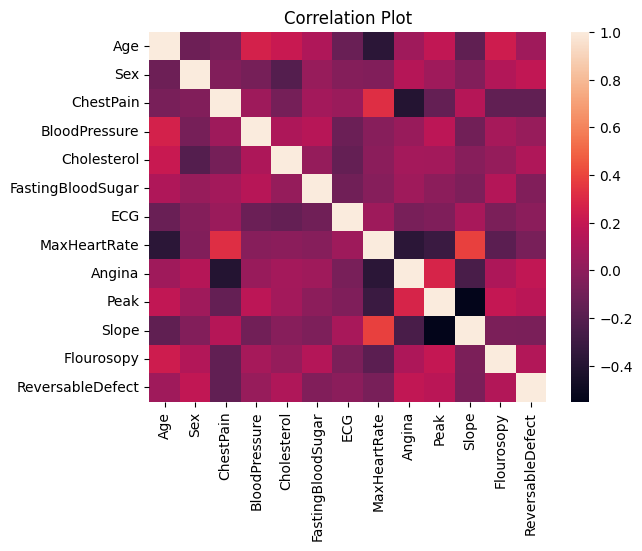

In [18]:
import seaborn as sns
sns.heatmap(X_train.select_dtypes(exclude='object').corr()).set_title('Correlation Plot')

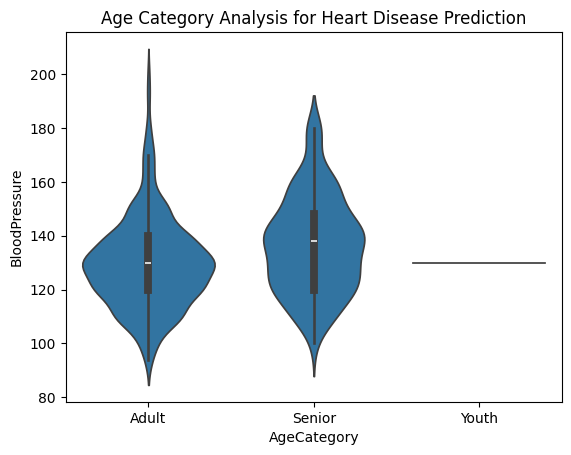

In [20]:
plt.title('Age Category Analysis for Heart Disease Prediction')
sns.violinplot(x='AgeCategory', y='BloodPressure', data=X_train)
plt.show()

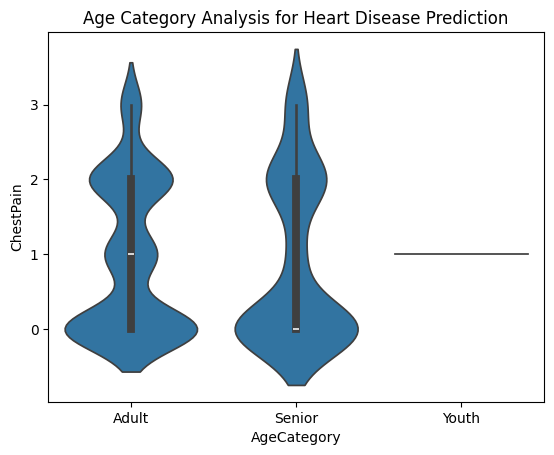

In [21]:
plt.title('Age Category Analysis for Heart Disease Prediction')
sns.violinplot(x='AgeCategory', y='ChestPain', data=X_train)
plt.show()

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin): 
    # Train our custom preprocessors 
    numerical_columns = [
        'Age',
        'BloodPressure',
        'Cholesterol',
        'MaxHeartRate',
        'Peak'
    ]
    categorical_columns = [
        'Sex',
        'ChestPain',
        'FastingBloodSugar',
        'ECG',
        'Angina',
        'Slope',
        'Flourosopy',
        'ReversableDefect',
        'AgeCategory',
        'Smoker',
        'TreatmentType']
    
    def fit(self, X, y=None): 

        # Create and fit simple imputer
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[self.numerical_columns])
        
        # Create and fit Standard Scaler 
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.numerical_columns]) 
        
        # Create and fit one hot encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[self.categorical_columns])
        
        return self 

    def transform(self, X): 
        
        # Apply simple imputer 
        imputed_cols = self.imputer.transform(X[self.numerical_columns])
        onehot_cols = self.onehot.transform(X[self.categorical_columns])
        
        # Copy the df 
        transformed_df = X.copy()
         
        # Apply transformed columns
        transformed_df[self.numerical_columns] = imputed_cols
        transformed_df[self.numerical_columns] = self.scaler.transform(transformed_df[self.numerical_columns])        
        
        # Drop existing categorical columns and replace with one hot equivalent
        transformed_df = transformed_df.drop(self.categorical_columns, axis=1) 
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df

In [25]:
preprocessor = Preprocessor()
preprocessor.fit(X_train)
train_fixed = preprocessor.transform(X_train)

In [26]:
train_fixed

,Age,BloodPressure,Cholesterol,MaxHeartRate,Peak,Sex_0,Sex_1,ChestPain_0,ChestPain_1,ChestPain_2,...,ReversableDefect_3,AgeCategory_Adult,AgeCategory_Senior,AgeCategory_Youth,Smoker_Current Smoker,Smoker_Former Smoker,Smoker_Non-Smoker,TreatmentType_Lifestyle Changes,TreatmentType_Medication,TreatmentType_Surgery
315,-1.405034,0.947890,-0.058677,1.258177,-0.212795,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
204,1.262700,0.832696,0.595166,0.128065,-0.928291,1,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
363,-0.182322,-0.088854,-0.020216,1.040848,-0.928291,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
5,0.373456,-1.816760,0.018246,-1.175910,-0.033921,1,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
1017,-0.182322,-0.492032,0.672089,-2.349489,0.860450,0,1,1,0,0,...,1,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,-0.626945,-0.780016,-1.885593,-1.002047,-0.212795,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
192,1.373856,-0.952807,6.095144,0.475792,0.502702,1,0,0,0,1,...,1,0,1,0,0,0,1,1,0,0
629,1.151545,0.371921,0.672089,1.084314,0.323827,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
559,1.373856,-0.664822,-0.193292,-3.392669,-0.033921,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,1


In [27]:
train_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 820 entries, 315 to 684
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              820 non-null    float64
 1   BloodPressure                    820 non-null    float64
 2   Cholesterol                      820 non-null    float64
 3   MaxHeartRate                     820 non-null    float64
 4   Peak                             820 non-null    float64
 5   Sex_0                            820 non-null    int64  
 6   Sex_1                            820 non-null    int64  
 7   ChestPain_0                      820 non-null    int64  
 8   ChestPain_1                      820 non-null    int64  
 9   ChestPain_2                      820 non-null    int64  
 10  ChestPain_3                      820 non-null    int64  
 11  FastingBloodSugar_0              820 non-null    int64  
 12  FastingBloodSugar_1      

**LOGISTIC REGRESSION**

In [28]:
from sklearn.pipeline import make_pipeline
m1 = 'Logistic Regression'
lr = LogisticRegression()
lrf = make_pipeline(Preprocessor(),lr)

In [29]:
lrf

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('logisticregression', LogisticRegression())])

In [30]:
model = lrf.fit(X_train, y_train)

In [31]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
lr_predict_train = lrf.predict(X_train)
lr_predict = lrf.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print("Root mean squared error (Train)",root_mean_squared_error(y_train,lr_predict_train))
print("Mean Absolute Error (Train)",mean_absolute_error(y_train,lr_predict_train))
print("\n")
print("Root mean squared error (Test)",root_mean_squared_error(y_test,lr_predict))
print("Mean Absolute Error (Test)",mean_absolute_error(y_test,lr_predict))
print("\n")
print(classification_report(y_test,lr_predict))
rm2e = root_mean_squared_error(y_test,lr_predict)
mae = mean_absolute_error(y_test,lr_predict)

confussion matrix
[[ 84  14]
 [  6 101]]


Accuracy of Logistic Regression: 90.2439024390244 

Root mean squared error (Train) 0.3526900110613271
Mean Absolute Error (Train) 0.12439024390243902


Root mean squared error (Test) 0.31234752377721214
Mean Absolute Error (Test) 0.0975609756097561


              precision    recall  f1-score   support

           0       0.93      0.86      0.89        98
           1       0.88      0.94      0.91       107

    accuracy                           0.90       205
   macro avg       0.91      0.90      0.90       205
weighted avg       0.90      0.90      0.90       205



**MODEL 2 NAIVE BAYES ALGORITHM**

In [37]:
m2 = 'Naive Bayes'
nb = GaussianNB()
nbf = make_pipeline(Preprocessor(),nb)

In [38]:
model2 = nbf.fit(X_train,y_train)

In [39]:
nb_predict_train = nbf.predict(X_train)
nb_predict = nbf.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nb_predict)
nb_acc_score = accuracy_score(y_test, nb_predict)
print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes:",nb_acc_score*100,'\n')
print("Root mean squared error (Train) Naive Bayes",root_mean_squared_error(y_train,nb_predict_train))
print("Mean Absolute Error (Train) Naive Bayes",mean_absolute_error(y_train,nb_predict_train))
print("\n")
print("Root mean squared error (Test) Naive Bayes",root_mean_squared_error(y_test,nb_predict))
print("Mean Absolute Error (Test) Naive Bayes",mean_absolute_error(y_test,nb_predict))
print("\n")
print(classification_report(y_test,nb_predict))
nb_rm2e = root_mean_squared_error(y_test,nb_predict)
nb_mae = mean_absolute_error(y_test,nb_predict)

confussion matrix
[[95  3]
 [43 64]]


Accuracy of Naive Bayes: 77.5609756097561 

Root mean squared error (Train) Naive Bayes 0.5
Mean Absolute Error (Train) Naive Bayes 0.25


Root mean squared error (Test) Naive Bayes 0.47369847361210593
Mean Absolute Error (Test) Naive Bayes 0.22439024390243903


              precision    recall  f1-score   support

           0       0.69      0.97      0.81        98
           1       0.96      0.60      0.74       107

    accuracy                           0.78       205
   macro avg       0.82      0.78      0.77       205
weighted avg       0.83      0.78      0.77       205



**MODEL 3 RANDOM FOREST CLASSIFIER**

In [46]:
m3 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rff = make_pipeline(Preprocessor(),rf)

In [47]:
model3 = rff.fit(X_train,y_train)

In [48]:
rf_predict_train = rff.predict(X_train)
rf_predict = rff.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predict)
rf_acc_score = accuracy_score(y_test, rf_predict)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest Classfier:",rf_acc_score*100,'\n')
print("Root mean squared error (Train) Random Forest Classfier",root_mean_squared_error(y_train,rf_predict_train))
print("Mean Absolute Error (Train) Random Forest Classfier",mean_absolute_error(y_train,rf_predict_train))
print("\n")
print("Root mean squared error (Test) Random Forest Classfier",root_mean_squared_error(y_test,rf_predict))
print("Mean Absolute Error (Test) Random Forest Classfier",mean_absolute_error(y_test,rf_predict))
print("\n")
print(classification_report(y_test,rf_predict))
rf_rm2e = root_mean_squared_error(y_test,rf_predict)
rf_mae = mean_absolute_error(y_test,rf_predict)

confussion matrix
[[ 88  10]
 [  3 104]]


Accuracy of Random Forest Classfier: 93.65853658536587 

Root mean squared error (Train) Random Forest Classfier 0.27274574955888686
Mean Absolute Error (Train) Random Forest Classfier 0.07439024390243902


Root mean squared error (Test) Random Forest Classfier 0.2518226243734694
Mean Absolute Error (Test) Random Forest Classfier 0.06341463414634146


              precision    recall  f1-score   support

           0       0.97      0.90      0.93        98
           1       0.91      0.97      0.94       107

    accuracy                           0.94       205
   macro avg       0.94      0.93      0.94       205
weighted avg       0.94      0.94      0.94       205



**MODEL 4 EXTREME GRADIENT BOOST ALGORITHM**

In [56]:
m4 = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgbf = make_pipeline(Preprocessor(),xgb)

In [57]:
model4 = xgbf.fit(X_train, y_train)

In [58]:
xgb_predict_train = xgbf.predict(X_train)
xgb_predict = xgbf.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predict)
xgb_acc_score = accuracy_score(y_test, xgb_predict)
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of EXTREME GRADIENT BOOST ALGORITHM:",xgb_acc_score*100,'\n')
print("Root mean squared error (Train) GRADIENT BOOST ALGORITHM",root_mean_squared_error(y_train,xgb_predict_train))
print("Mean Absolute Error (Train) GRADIENT BOOST ALGORITHM",mean_absolute_error(y_train,xgb_predict_train))
print("\n")
print("Root mean squared error (Test) GRADIENT BOOST ALGORITHM",root_mean_squared_error(y_test,xgb_predict))
print("Mean Absolute Error (Test) GRADIENT BOOST ALGORITHM",mean_absolute_error(y_test,xgb_predict))
print("\n")
print(classification_report(y_test,xgb_predict))
xgb_rm2e = root_mean_squared_error(y_test,xgb_predict)
xgb_mae = mean_absolute_error(y_test,xgb_predict)

confussion matrix
[[ 86  12]
 [  6 101]]


Accuracy of EXTREME GRADIENT BOOST ALGORITHM: 91.21951219512195 

Root mean squared error (Train) GRADIENT BOOST ALGORITHM 0.32384880543316474
Mean Absolute Error (Train) GRADIENT BOOST ALGORITHM 0.1048780487804878


Root mean squared error (Test) GRADIENT BOOST ALGORITHM 0.29631887899487686
Mean Absolute Error (Test) GRADIENT BOOST ALGORITHM 0.08780487804878048


              precision    recall  f1-score   support

           0       0.93      0.88      0.91        98
           1       0.89      0.94      0.92       107

    accuracy                           0.91       205
   macro avg       0.91      0.91      0.91       205
weighted avg       0.91      0.91      0.91       205



**MODEL 5 DECISION TREE CLASSIFIER**

In [61]:
m5 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dtf = make_pipeline(Preprocessor(),dt)


In [62]:
model5 = dtf.fit(X_train, y_train)

In [63]:
dt_predict_train = dtf.predict(X_train)
dt_predict = dtf.predict(X_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predict)
dt_acc_score = accuracy_score(y_test, dt_predict)
print("confussion matrix")
print(dt_conf_matrix)
print("\n")
print("Accuracy of DECISION TREE CLASSIFIER:",dt_acc_score*100,'\n')
print("Root mean squared error (Train) DECISION TREE CLASSIFIER",root_mean_squared_error(y_train,dt_predict_train))
print("Mean Absolute Error (Train) DECISION TREE CLASSIFIER",mean_absolute_error(y_train,dt_predict_train))
print("\n")
print("Root mean squared error (Test) DECISION TREE CLASSIFIER",root_mean_squared_error(y_test,dt_predict))
print("Mean Absolute Error (Test) DECISION TREE CLASSIFIER",mean_absolute_error(y_test,dt_predict))
print("\n")
print(classification_report(y_test,dt_predict))
dt_rm2e = root_mean_squared_error(y_test,dt_predict)
dt_mae = mean_absolute_error(y_test,dt_predict)

confussion matrix
[[86 12]
 [ 8 99]]


Accuracy of DECISION TREE CLASSIFIER: 90.2439024390244 

Root mean squared error (Train) DECISION TREE CLASSIFIER 0.25423246516026116
Mean Absolute Error (Train) DECISION TREE CLASSIFIER 0.06463414634146342


Root mean squared error (Test) DECISION TREE CLASSIFIER 0.31234752377721214
Mean Absolute Error (Test) DECISION TREE CLASSIFIER 0.0975609756097561


              precision    recall  f1-score   support

           0       0.91      0.88      0.90        98
           1       0.89      0.93      0.91       107

    accuracy                           0.90       205
   macro avg       0.90      0.90      0.90       205
weighted avg       0.90      0.90      0.90       205



**MODEL 6 SUPPORT VECTOR CLASSIFIER**

In [65]:
m6 = 'Support Vector Classifier'
svc =  SVC(kernel='rbf', C=2)
svcf = make_pipeline(Preprocessor(),svc)

In [66]:
model6 = svcf.fit(X_train, y_train)


In [67]:
svc_predict_train = svcf.predict(X_train)
svc_predict = svcf.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predict)
svc_acc_score = accuracy_score(y_test, svc_predict)
print("confussion matrix")
print(svc_conf_matrix)
print("\n")
print("Accuracy of SUPPORT VECTOR CLASSIFIER:",dt_acc_score*100,'\n')
print("Root mean squared error (Train) SUPPORT VECTOR CLASSIFIER",root_mean_squared_error(y_train,svc_predict_train))
print("Mean Absolute Error (Train) SUPPORT VECTOR CLASSIFIER",mean_absolute_error(y_train,svc_predict_train))
print("\n")
print("Root mean squared error (Test) SUPPORT VECTOR CLASSIFIER",root_mean_squared_error(y_test,svc_predict))
print("Mean Absolute Error (Test) SUPPORT VECTOR CLASSIFIER",mean_absolute_error(y_test,svc_predict))
print("\n")
print(classification_report(y_test,svc_predict))
svc_rm2e = root_mean_squared_error(y_test,svc_predict)
svc_mae = mean_absolute_error(y_test,svc_predict)

confussion matrix
[[ 92   6]
 [  0 107]]


Accuracy of SUPPORT VECTOR CLASSIFIER: 90.2439024390244 

Root mean squared error (Train) SUPPORT VECTOR CLASSIFIER 0.16003048490072438
Mean Absolute Error (Train) SUPPORT VECTOR CLASSIFIER 0.025609756097560974


Root mean squared error (Test) SUPPORT VECTOR CLASSIFIER 0.17107978455366032
Mean Absolute Error (Test) SUPPORT VECTOR CLASSIFIER 0.02926829268292683


              precision    recall  f1-score   support

           0       1.00      0.94      0.97        98
           1       0.95      1.00      0.97       107

    accuracy                           0.97       205
   macro avg       0.97      0.97      0.97       205
weighted avg       0.97      0.97      0.97       205



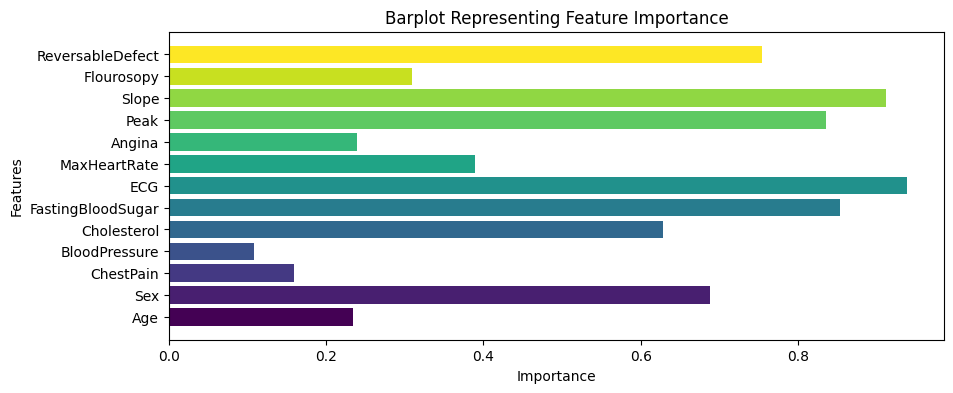

In [68]:
feature_importances = np.random.rand(13)  # This should be replaced with xgb.feature_importances_

# Creating a DataFrame
imp_feature = pd.DataFrame({
    'Feature': ['Age', 'Sex', 'ChestPain', 'BloodPressure', 'Cholesterol', 'FastingBloodSugar', 'ECG', 'MaxHeartRate', 
                'Angina', 'Peak', 'Slope', 'Flourosopy', 'ReversableDefect'],
    'Importance': feature_importances
})

# Plotting
plt.figure(figsize=(10, 4))
plt.title("Barplot Representing Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

# Using a colormap if there are more features than colors
colors = plt.cm.viridis(np.linspace(0, 1, len(imp_feature['Feature'])))
plt.barh(imp_feature['Feature'], imp_feature['Importance'], color=colors)

plt.show()

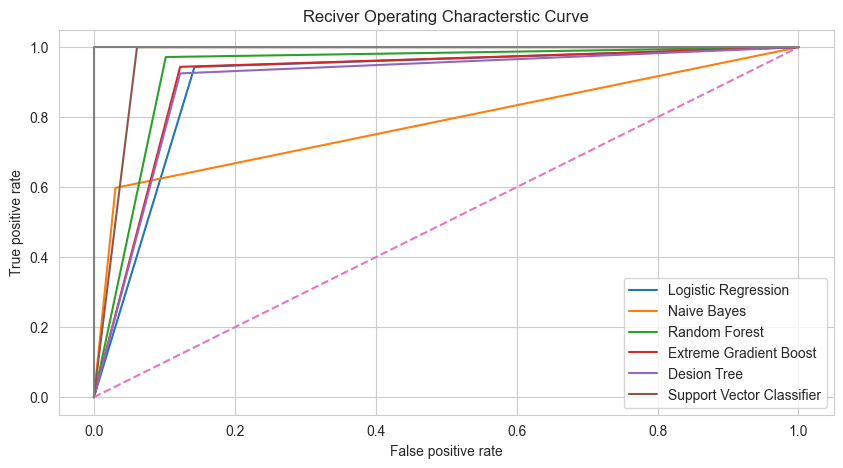

In [72]:
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,lr_predict)
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = roc_curve(y_test,nb_predict)
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_predict)                                                             
xgb_false_positive_rate,xgb_true_positive_rate,xgb_threshold = roc_curve(y_test,xgb_predict)
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = roc_curve(y_test,dt_predict)
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = roc_curve(y_test,svc_predict)


sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(xgb_false_positive_rate,xgb_true_positive_rate,label='Extreme Gradient Boost')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

In [74]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','Naive Bayes','Random Forest','Extreme Gradient Boost',
                    'Decision Tree','Support Vector Machine'], 'Accuracy': [lr_acc_score*100,
                    nb_acc_score*100,rf_acc_score*100,xgb_acc_score*100,dt_acc_score*100,svc_acc_score*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,90.243902
1,Naive Bayes,77.560976
2,Random Forest,93.658537
3,Extreme Gradient Boost,91.219512
4,Decision Tree,90.243902
5,Support Vector Machine,97.073171


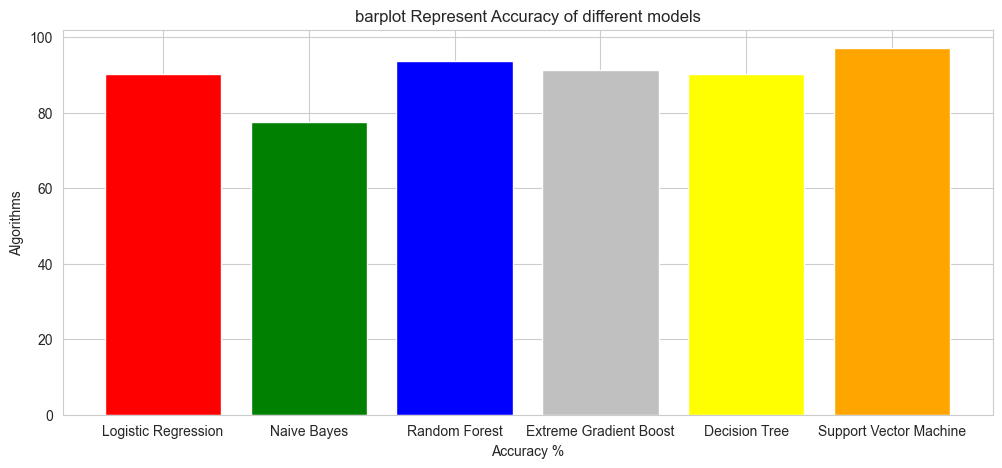

In [75]:
colors = ['red','green','blue','silver','yellow','orange',]
plt.figure(figsize=(12,5))
plt.title("barplot Represent Accuracy of different models")
plt.xlabel("Accuracy %")
plt.ylabel("Algorithms")
plt.bar(model_ev['Model'],model_ev['Accuracy'],color = colors)
plt.show()

In [76]:
lr_params = lrf.get_params()
lr_params

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'logisticregression': LogisticRegression(),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [77]:
nb_params = nbf.get_params()
nb_params

{'memory': None,
 'steps': [('preprocessor', Preprocessor()), ('gaussiannb', GaussianNB())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'gaussiannb': GaussianNB(),
 'gaussiannb__priors': None,
 'gaussiannb__var_smoothing': 1e-09}

In [78]:
rf_params = rff.get_params()
rf_params

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('randomforestclassifier',
   RandomForestClassifier(max_depth=5, n_estimators=20, random_state=12))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'randomforestclassifier': RandomForestClassifier(max_depth=5, n_estimators=20, random_state=12),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__monotonic_cst': None,
 'randomforestclassifier__n_estimators': 20,
 'randomforestc

In [79]:
xgb_params = xgbf.get_params()
xgb_params

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster='dart', callbacks=None,
                 colsample_bylevel=0.6, colsample_bynode=0.5, colsample_bytree=0.6,
                 device=None, early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, gamma=0.6, grow_policy=None,
                 importance_type=None, interaction_constraints=None,
                 learning_rate=0.01, max_bin=None, max_cat_threshold=None,
                 max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
                 max_leaves=None, min_child_weight=None, missing=nan,
                 monotone_constraints=None, multi_strategy=None, n_estimators=25,
                 n_jobs=None, num_parallel_tree=None, random_state=None, ...))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'xgbclassifier': XGBClassifier(base_score=None, booster='dart', callbacks=None,
              

In [80]:
dt_params = dtf.get_params()
dt_params

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('decisiontreeclassifier',
   DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0),
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 6,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__monotonic_cst': None,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best'}

In [81]:
svc_params = svcf.get_params()
svc_params

{'memory': None,
 'steps': [('preprocessor', Preprocessor()), ('svc', SVC(C=2))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'svc': SVC(C=2),
 'svc__C': 2,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [94]:
#MODEL REGISTRATION CODE AT ML FLOW FOR TRACKING AND COMPARING MODEL
import mlflow
from mlflow.models import infer_signature

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

mlflow.set_experiment("Heart Disease Prediction Project")

with mlflow.start_run():
    mlflow.log_params(rf_params)

    mlflow.log_metric("root_mean_squared_error", rf_rm2e)
    mlflow.log_metric("mean_absolute_error", rf_mae)
    mlflow.log_metric("Accuracy", rf_acc_score*100)

    mlflow.set_tag("Training Info", "Random Forest for Heart Disease Prediction,n_estimators=70")

    signature = infer_signature(X_train, rff.predict(X_train))

    model_info = mlflow.sklearn.log_model(
        sk_model=rff,
        artifact_path="heart_disease_prediction_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="random_forest_model_n_estimators=70",
    )

/Users/vaibhavbansal/anaconda3/envs/new_ml_pipeline/lib/python3.12/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'random_forest_model_n_estimators=70'.
2024/05/15 04:00:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model

In [101]:
import json
import requests

payload = json.dumps({'inputs': {
    "Age": 63,
    "Sex": 1,
    "ChestPain": 3,
    "BloodPressure": 145,
    "Cholesterol": 233,
    "FastingBloodSugar": 1,
    "ECG": 0,
    "MaxHeartRate": 150,
    "Angina": 0,
    "Peak": 2.3,
    "Slope": 0,
    "Flourosopy": 0,
    "ReversableDefect": 1,
    "AgeCategory":"Senior",
    "Smoker":"Current Smoker",
    "TreatmentType":"Medication"
}})
response = requests.post(
    url=f"http://127.0.0.1:5000/invocations",
    data=payload,
    headers={"Content-Type": "application/json"},
)
print(response.json())

{'predictions': [1]}


In [102]:
import json
import numpy as np

# Custom JSON encoder class for handling numpy data types
class NumpyEncoder(json.JSONEncoder):
    """Custom encoder for numpy data types."""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# Dictionary with various types of data, some of which are numpy data types
options = {
    'Age': (np.int64(29), np.int64(77)),
    'BloodPressure': (np.int64(94), np.int64(200)),
    'Cholesterol': (np.int64(126), np.int64(564)),
    'MaxHeartRate': (np.int64(71), np.int64(202)),
    'Peak': (np.float64(0.0), np.float64(6.2)),
    'Sex': [0, 1],
    'ChestPain': [0, 1, 2, 3],
    'FastingBloodSugar': [0, 1],
    'ECG': [0, 1, 2],
    'Angina': [0, 1],
    'Slope': [0, 1, 2],
    'Flourosopy': [0, 1, 2, 3, 4],
    'ReversableDefect': [0, 1, 2, 3],
    'AgeCategory': ['Adult', 'Senior', 'Youth'],
    'Smoker': ['Current Smoker', 'Former Smoker', 'Non-Smoker'],
    'TreatmentType': ['Lifestyle Changes', 'Medication', 'Surgery']
}

# Serialize the dictionary to a JSON file
with open('input_options.json', 'w') as f:
    json.dump(options, f, cls=NumpyEncoder, indent=2, sort_keys = True)

print("JSON file has been created with the serialized options.")


JSON file has been created with the serialized options.
